In [1]:
import random
import pickle
from pathlib import Path
from functools import partial

import anndata as ad
import h5py
import jax
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pydensecrf.densecrf as dcrf
import orbax.checkpoint as ocp
import tensorflow as tf
from sklearn.metrics import PrecisionRecallDisplay
from tqdm import tqdm
from chioso.data import SGData2D, SGDataset2D
from xtrain import GeneratorAdapter, Adversal, Trainer

binning = 2

data_path = Path("chioso_val_dataset/synthetic_drop_0.8/")
data_files = sorted(list(data_path.glob("*.h5")))
checkpoint = Path("synthetic_log/checkpoint_3/")

In [2]:
def scale_label(label, factor=binning):
    label_ = jax.nn.one_hot(label, axis=-1, num_classes=4)
    h, w, c = label_.shape
    label_ = jax.image.resize(label_, (h//factor, w//factor, c), "linear")
    label_ = np.argmax(label_, axis=-1)
    return label_

def crf(u, sxy=1.5, compat=3):
    h, w, ncls = u.shape
    u = np.asarray(u, dtype="float32")
    d = dcrf.DenseCRF2D(w, h, ncls)
    d.setUnaryEnergy(np.ascontiguousarray(u.transpose(2,0,1).reshape(ncls, -1)))
    d.addPairwiseGaussian(sxy=sxy, compat=compat)
    q = np.argmax(d.inference(5), axis=0).reshape(h, w)
    return q

### Check input data

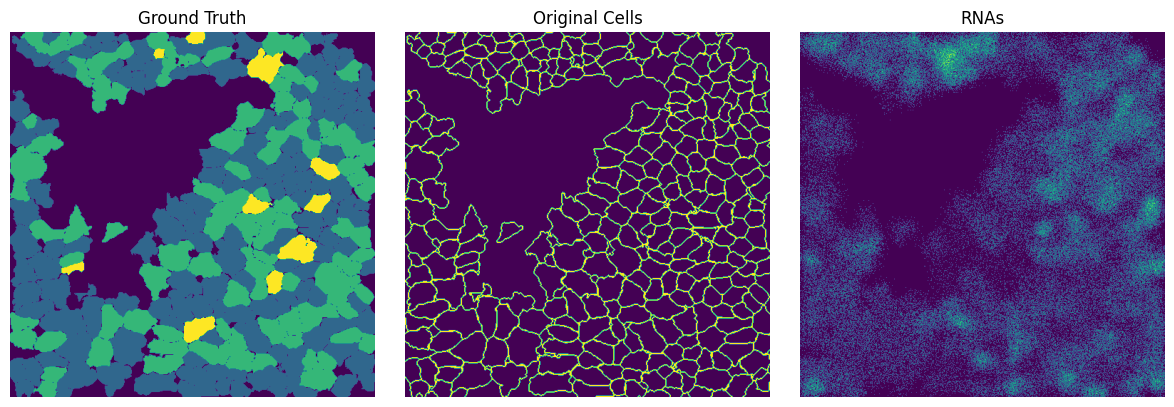

In [3]:
from skimage.segmentation import find_boundaries

with h5py.File(data_files[10]) as f:
    sg = SGDataset2D(f["X"])[:, :]
    label = f["label"][...]
    seg = f['orig_segm'][...]
fig,ax = plt.subplots(1,3, figsize=(12,4))
ax[2].imshow(np.log1p(sg.render()))
ax[2].set_title("RNAs")
ax[0].imshow(label)
ax[0].set_title("Ground Truth")
ax[1].imshow(find_boundaries(seg))
ax[1].set_title("Original Cells")
[a.axis('off') for a in ax]
plt.tight_layout()

### Read model

In [4]:
with open(checkpoint/"model_def.pickle", "rb") as f:
    model = pickle.load(f)

params = ocp.StandardCheckpointer().restore(
    (checkpoint/"model").absolute(),
)["train_state"]["params"]

apply_fn = jax.jit(partial(
    model.apply, 
    dict(params=params),
    mutable="adversal",
    training=False,
))

2024-05-21 15:23:19.518767: W external/xla/xla/service/gpu/nvptx_compiler.cc:744] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


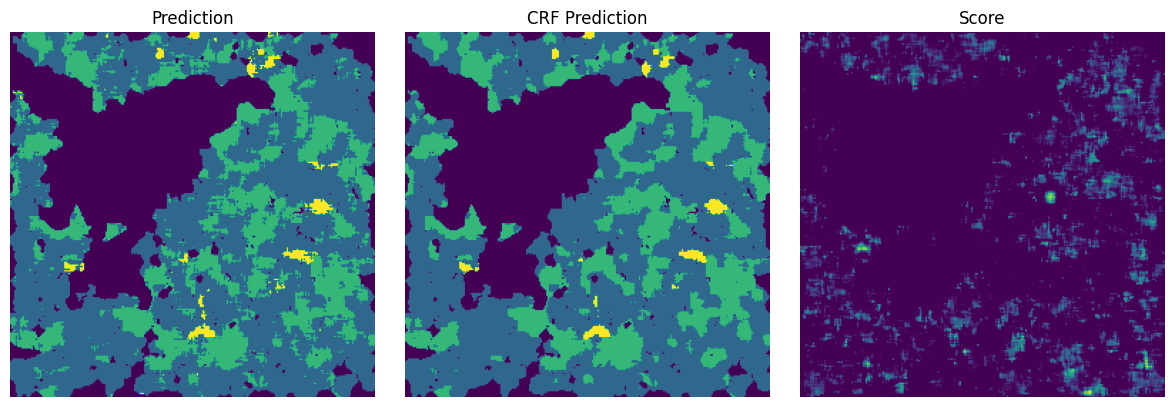

In [5]:
# show one example

pred,_ = apply_fn(sg.binning((binning,binning)))
pred_label = np.argmax(pred["output"], axis=-1)
pred_label = np.array([2,0,1])[pred_label]

output = pred["output"]
logits = jax.nn.log_softmax(output)
pred_label_crf = crf(-logits, compat=10)
pred_label_crf = np.array([2,0,1])[pred_label_crf]

scaled_gt_label = scale_label(label)

fig,ax = plt.subplots(1,3, figsize=(12,4))

ax[0].imshow((pred_label+1) * (scaled_gt_label>0))
ax[0].set_title("Prediction")
ax[2].imshow(pred["dsc_loss_main"])
ax[2].set_title("Score")

ax[1].imshow((pred_label_crf + 1) * (scaled_gt_label>0))
ax[1].set_title("CRF Prediction")
[a.axis('off') for a in ax]
plt.tight_layout()

### pixels level Metrics

100%|██████████| 500/500 [01:40<00:00,  4.97it/s]


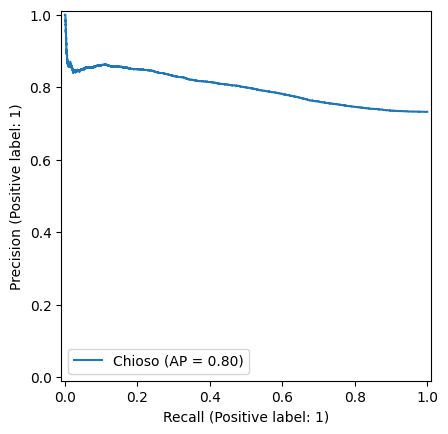

In [6]:
pred_, gt_, score_ = [], [], []
for fn in tqdm(data_files):
    with h5py.File(data_files[10]) as f:
        sg = SGDataset2D(f["X"])[:, :]
        label = f["label"][...]
    sg = sg.binning((binning,binning))
    sg = sg.pad_to_bucket_size(524288)

    label = scale_label(label, binning)

    gt_.append(label[label != 0])

    pred, _ = apply_fn(sg)

    # output = pred["output"]
    # logits = jax.nn.log_softmax(output)
    # pred_label = crf(-logits, compat=30)
    pred_label = np.argmax(pred["output"], axis=-1)
    # pred_score = jax.nn.softmax(pred["output"]).max(axis=-1)
    
    score_.append(np.array(pred["dsc_loss_main"])[label != 0])
    # score_.append(np.array(pred_score)[label != 0])
    pred_.append(pred_label[label != 0])

pred_ = np.concatenate(pred_)
score_ = np.concatenate(score_)
gt_ = np.concatenate(gt_)

pred_ = np.array([3,1,2])[pred_]

display = PrecisionRecallDisplay.from_predictions(
    gt_ == pred_, score_, name="Chioso",
)

# display.ax_.axhline(y=0.33, color='k', ls="--")

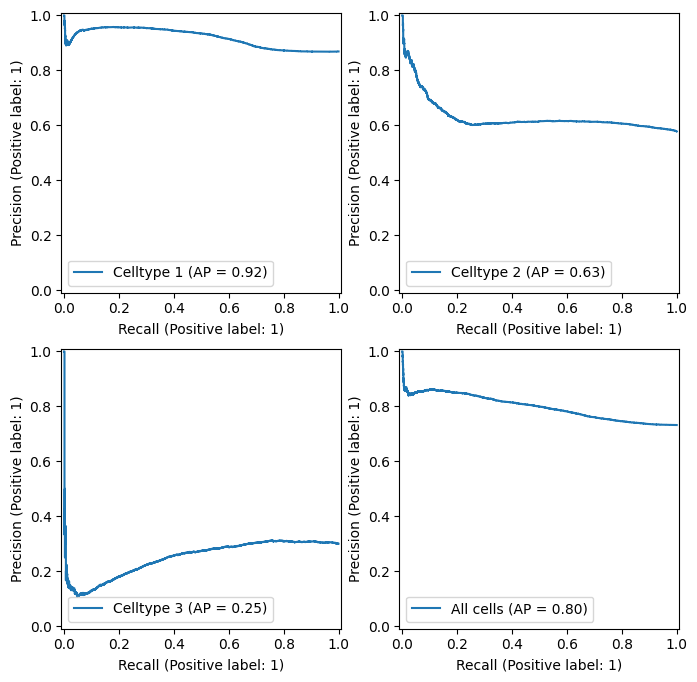

In [7]:
fig, ax = plt.subplots(2,2, figsize=(8,8))
binary_label = gt_ == pred_
ax = ax.reshape(-1)

for k in range(3):
    display = PrecisionRecallDisplay.from_predictions(
        binary_label[gt_== (k+1)], score_[gt_==(k+1)], name=f"Celltype {k+1}", ax= ax[k]
    )

display = PrecisionRecallDisplay.from_predictions(
    binary_label, score_, name="All cells", ax=ax[3]
)


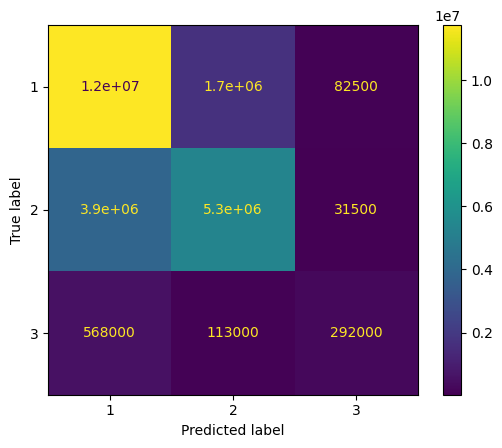

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay

display = ConfusionMatrixDisplay.from_predictions(gt_[gt_>0], pred_[gt_>0])

In [9]:
from sklearn.metrics import classification_report
print(classification_report(gt_, pred_))

              precision    recall  f1-score   support

           1       0.73      0.87      0.79  13515500
           2       0.75      0.58      0.65   9244000
           3       0.72      0.30      0.42    973000

    accuracy                           0.73  23732500
   macro avg       0.73      0.58      0.62  23732500
weighted avg       0.73      0.73      0.72  23732500



### Per cell metrics

100%|██████████| 500/500 [01:47<00:00,  4.64it/s]


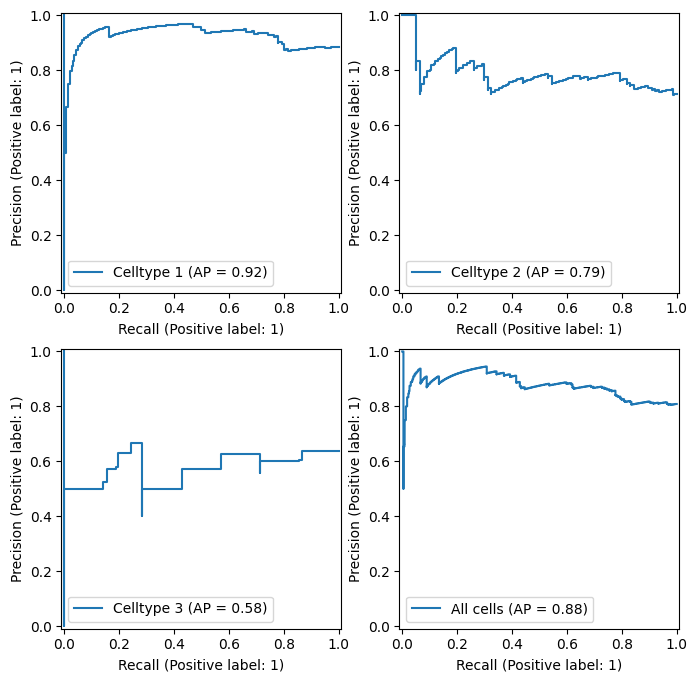

In [10]:
from skimage.measure import regionprops

pred_, gt_, score_ = [], [], []
for fn in tqdm(data_files):
    with h5py.File(data_files[10]) as f:
        sg = SGDataset2D(f["X"])[:, :]
        label = f["label"][...]
        seg = f['orig_segm'][...]
    sg = sg.binning((binning,binning))
    sg = sg.pad_to_bucket_size(524288)

    label = scale_label(label, binning)

    cell_locs = np.array([rp.centroid for rp in regionprops(seg)])
    cell_locs = (cell_locs / binning).astype(int)

    gt_.append(label[cell_locs[:,0], cell_locs[:,1]])

    pred, _ = apply_fn(sg)
    pred_label = np.argmax(pred["output"], axis=-1)
    
    score_.append(np.array(pred["dsc_loss_main"])[cell_locs[:,0], cell_locs[:,1]])
    pred_.append(pred_label[cell_locs[:,0], cell_locs[:,1]])

pred_ = np.concatenate(pred_)
score_ = np.concatenate(score_)
gt_ = np.concatenate(gt_)

valid = gt_ > 0
gt_ = gt_[valid]
score_ = score_[valid]
pred_ = pred_[valid]
pred_ = np.array([3,1,2])[pred_]

fig, ax = plt.subplots(2,2, figsize=(8,8))
binary_label = gt_ == pred_
ax = ax.reshape(-1)

for k in range(3):
    display = PrecisionRecallDisplay.from_predictions(
        binary_label[gt_== (k+1)], score_[gt_==(k+1)], name=f"Celltype {k+1}", ax= ax[k]
    )

display = PrecisionRecallDisplay.from_predictions(
    binary_label, score_, name="All cells", ax=ax[3]
)


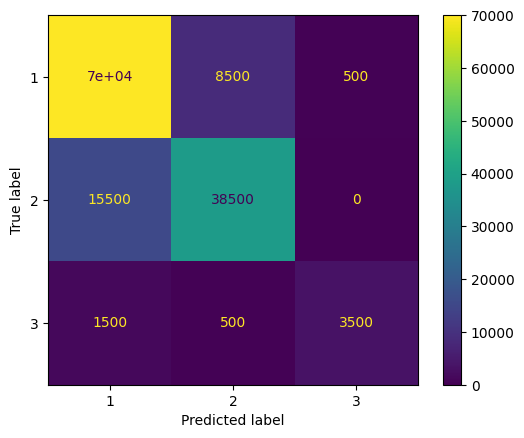

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay

display = ConfusionMatrixDisplay.from_predictions(gt_[gt_>0], pred_[gt_>0])

In [12]:
from sklearn.metrics import classification_report


print(classification_report(gt_, pred_))

              precision    recall  f1-score   support

           1       0.80      0.89      0.84     79000
           2       0.81      0.71      0.76     54000
           3       0.88      0.64      0.74      5500

    accuracy                           0.81    138500
   macro avg       0.83      0.75      0.78    138500
weighted avg       0.81      0.81      0.81    138500

